## 1. Imports et Configuration

In [1]:
!pip install -q lightgbm catboost

In [2]:
# Imports standards
import pandas as pd
import numpy as np
import pickle
import os
import warnings
from datetime import datetime
import time

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Machine Learning - Modèles
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score,
    confusion_matrix, classification_report,
    roc_curve, precision_recall_curve,
    ConfusionMatrixDisplay
)

# Optional models (fallback if not installed)
HAS_XGB, HAS_LGBM, HAS_CAT = True, True, True
try:
    from xgboost import XGBClassifier
except Exception:
    HAS_XGB = False

try:
    from lightgbm import LGBMClassifier
except Exception:
    HAS_LGBM = False

try:
    from catboost import CatBoostClassifier
except Exception:
    HAS_CAT = False

# Configuration
warnings.filterwarnings('ignore')
np.random.seed(42)

# Configuration des graphiques
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print(" Tous les packages importés avec succès!")
print(f" Date d'exécution: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Libs dispo -> XGBoost={HAS_XGB} | LightGBM={HAS_LGBM} | CatBoost={HAS_CAT}")


 Tous les packages importés avec succès!
 Date d'exécution: 2026-01-11 15:02:55
Libs dispo -> XGBoost=True | LightGBM=True | CatBoost=True


## 2.  Chargement des Données Preprocessées

In [3]:
# Définir le chemin vers les processeurs
PROCESSOR_DIR = 'processors'

def load_preprocessed_data(processor_dir=PROCESSOR_DIR):
    """
    Charge les données preprocessées et les processeurs
    """
    print(f"{'='*80}")
    print("CHARGEMENT DES DONNÉES PREPROCESSÉES - CHURN")
    print(f"{'='*80}")

    data_path = os.path.join(processor_dir, "preprocessed_data.pkl")
    feature_path = os.path.join(processor_dir, "feature_names.pkl")

    with open(data_path, "rb") as f:
        datasets = pickle.load(f)

    feature_names = None
    if os.path.exists(feature_path):
        with open(feature_path, "rb") as f:
            feature_names = pickle.load(f)

    X_train = datasets["X_train"]
    X_test  = datasets["X_test"]
    y_train = datasets["y_train"]
    y_test  = datasets["y_test"]

    print(f" X_train: {X_train.shape} | y_train: {pd.Series(y_train).value_counts().to_dict()}")
    print(f" X_test : {X_test.shape}  | y_test : {pd.Series(y_test).value_counts().to_dict()}")
    if feature_names is not None:
        print(f" Feature names: {len(feature_names)}")
    else:
        print(" feature_names.pkl introuvable (ce n'est pas bloquant).")

    return X_train, X_test, y_train, y_test, feature_names

X_train, X_test, y_train, y_test, feature_names = load_preprocessed_data()


CHARGEMENT DES DONNÉES PREPROCESSÉES - CHURN
 X_train: (8101, 35) | y_train: {0: 6799, 1: 1302}
 X_test : (2026, 35)  | y_test : {0: 1701, 1: 325}
 Feature names: 35


## 3.  Phase 1: Modèles de Base (Baseline)

In [4]:
def get_baseline_models():
    """
    Modèles avancés optimisés pour la prédiction du churn bancaire
    (SMOTE déjà appliqué → PAS de class_weight)
    """
    models = {}

    # Logistic Regression (baseline solide après SMOTE)
    models["Logistic Regression"] = LogisticRegression(
        penalty="l2",
        C=0.3,
        solver="liblinear",
        max_iter=1000
    )

    # Random Forest (très robuste en churn)
    models["Random Forest"] = RandomForestClassifier(
        n_estimators=600,
        max_depth=12,
        min_samples_split=50,
        min_samples_leaf=40,
        max_features="sqrt",
        random_state=42,
        n_jobs=-1
    )

    # Gradient Boosting (souvent meilleur que XGB par défaut)
    models["Gradient Boosting"] = GradientBoostingClassifier(
        n_estimators=300,
        learning_rate=0.03,
        max_depth=4,
        min_samples_leaf=50,
        subsample=0.8,
        random_state=42
    )

    # XGBoost (version churn-aware sans scale_pos_weight car SMOTE)
    if HAS_XGB:
        models["XGBoost"] = XGBClassifier(
            n_estimators=600,
            learning_rate=0.03,
            max_depth=5,
            min_child_weight=40,
            subsample=0.8,
            colsample_bytree=0.8,
            gamma=0.1,
            eval_metric="auc",
            random_state=42,
            n_jobs=-1
        )

    # LightGBM (stable après SMOTE)
    if HAS_LGBM:
        models["LightGBM"] = LGBMClassifier(
            n_estimators=500,
            learning_rate=0.03,
            num_leaves=31,
            min_child_samples=40,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1
        )

    # CatBoost (excellent en churn tabulaire)
    if HAS_CAT:
        models["CatBoost"] = CatBoostClassifier(
            iterations=800,
            learning_rate=0.03,
            depth=6,
            l2_leaf_reg=10,
            loss_function="Logloss",
            eval_metric="AUC",
            random_seed=42,
            verbose=False
        )

    print("=" * 80)
    print("MODÈLES AVANCÉS CONFIGURÉS POUR LE CHURN (POST-SMOTE)")
    print("=" * 80)
    for i, name in enumerate(models.keys(), 1):
        print(f"{i}. {name}")

    return models


baseline_models = get_baseline_models()


MODÈLES AVANCÉS CONFIGURÉS POUR LE CHURN (POST-SMOTE)
1. Logistic Regression
2. Random Forest
3. Gradient Boosting
4. XGBoost
5. LightGBM
6. CatBoost


## 4.  Entraînement des Modèles Baseline

In [5]:
import time
import numpy as np

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score
)

def _get_scores(model, X):
    """
    Retourne un score continu (proba ou decision_function) pour AUC/PR-AUC.
    """
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X)
        # cas binaire normal: shape (n,2)
        if proba.ndim == 2 and proba.shape[1] >= 2:
            return proba[:, 1]
        # fallback si shape inattendue
        return proba.ravel()

    if hasattr(model, "decision_function"):
        return model.decision_function(X)

    # fallback: utiliser prédiction binaire (moins bon pour AUC)
    return model.predict(X)


def train_and_evaluate_models(models, X_train, y_train, X_test, y_test, model_type="Baseline"):
    """
    Entraîne et évalue tous les modèles
    """
    print(f"\n{'='*80}")
    print(f"ENTRAÎNEMENT & ÉVALUATION - {model_type.upper()} (CHURN)")
    print(f"{'='*80}\n")

    results = {}

    for name, model in models.items():
        print(f"🔹 Modèle: {name}")

        start_time = time.time()
        model.fit(X_train, y_train)
        training_time = time.time() - start_time

        y_pred = model.predict(X_test)
        y_score = _get_scores(model, X_test)

        # --- Métriques principales (classe positive = churn = 1) ---
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
        rec = recall_score(y_test, y_pred, pos_label=1, zero_division=0)
        f1 = f1_score(y_test, y_pred, pos_label=1, zero_division=0)

        # AUC / PR-AUC : gère le cas rare où y_score est constant
        try:
            roc_auc = roc_auc_score(y_test, y_score)
        except ValueError:
            roc_auc = np.nan

        try:
            pr_auc = average_precision_score(y_test, y_score)
        except ValueError:
            pr_auc = np.nan

        metrics = {
            "accuracy": acc,
            "precision": prec,   # precision churn (classe 1)
            "recall": rec,       # recall churn (classe 1)
            "f1_score": f1,
            "roc_auc": roc_auc,
            "pr_auc": pr_auc     # très utile churn
        }

        results[name] = {
            "model": model,
            "model_type": model_type,
            "training_time": training_time,
            "metrics": metrics,
            "y_pred": y_pred,
            "y_score": y_score
        }

        # --- Affichage complet (inclut precision + recall) ---
        print(
            f"   • Accuracy: {acc:.4f} | Precision(churn): {prec:.4f} | Recall(churn): {rec:.4f} | F1(churn): {f1:.4f}"
        )
        print(
            f"   • ROC-AUC: {roc_auc:.4f} | PR-AUC: {pr_auc:.4f}"
        )
        print(f"   • Temps entraînement: {training_time:.2f}s\n")

    return results


baseline_results = train_and_evaluate_models(
    baseline_models, X_train, y_train, X_test, y_test, model_type="Baseline"
)



ENTRAÎNEMENT & ÉVALUATION - BASELINE (CHURN)

🔹 Modèle: Logistic Regression
   • Accuracy: 0.9008 | Precision(churn): 0.7743 | Recall(churn): 0.5385 | F1(churn): 0.6352
   • ROC-AUC: 0.9170 | PR-AUC: 0.7372
   • Temps entraînement: 0.08s

🔹 Modèle: Random Forest
   • Accuracy: 0.9062 | Precision(churn): 0.8649 | Recall(churn): 0.4923 | F1(churn): 0.6275
   • ROC-AUC: 0.9618 | PR-AUC: 0.8454
   • Temps entraînement: 2.72s

🔹 Modèle: Gradient Boosting
   • Accuracy: 0.9669 | Precision(churn): 0.9607 | Recall(churn): 0.8277 | F1(churn): 0.8893
   • ROC-AUC: 0.9904 | PR-AUC: 0.9610
   • Temps entraînement: 16.22s

🔹 Modèle: XGBoost
   • Accuracy: 0.9576 | Precision(churn): 0.9283 | Recall(churn): 0.7969 | F1(churn): 0.8576
   • ROC-AUC: 0.9840 | PR-AUC: 0.9366
   • Temps entraînement: 2.15s

🔹 Modèle: LightGBM
[LightGBM] [Info] Number of positive: 1302, number of negative: 6799
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001104 seconds.
You can 

## 5. 🔧 Phase 2: Fine-Tuning avec RandomizedSearchCV

### 5.1 Définition des Hyperparamètres à Tester

In [6]:
def get_param_distributions():
    """
    Définit les distributions de paramètres pour RandomizedSearchCV
    Adapté au churn bancaire avec SMOTE déjà appliqué (donc pas de class_weight / scale_pos_weight)
    """
    import numpy as np

    param_distributions = {

        # ✅ Logistic Regression (post-SMOTE : pas de class_weight)
        'Logistic Regression': {
            'C': np.logspace(-3, 1, 20),     # 1e-3 -> 10
            'penalty': ['l2'],
            'solver': ['liblinear'],         # plus stable pour petits/moyens datasets
            'max_iter': [500, 1000, 2000]
        },

        # ✅ Random Forest (régularisé pour généraliser + éviter overfit post-SMOTE)
        'Random Forest': {
            'n_estimators': [400, 600, 800, 1000],
            'max_depth': [8, 10, 12, 14, None],
            'min_samples_split': [20, 30, 50, 80],
            'min_samples_leaf': [10, 20, 30, 40, 60],
            'max_features': ['sqrt', 'log2', 0.6, 0.8]
            # ⚠️ pas de class_weight avec SMOTE
        },

        # ✅ Gradient Boosting (important vu tes scores)
        'Gradient Boosting': {
            'n_estimators': [200, 300, 400, 600],
            'learning_rate': [0.01, 0.02, 0.03, 0.05],
            'max_depth': [2, 3, 4],
            'min_samples_leaf': [20, 30, 50, 80],
            'subsample': [0.7, 0.8, 0.9, 1.0]
        },

        # ✅ XGBoost (post-SMOTE : pas de scale_pos_weight)
        'XGBoost': {
            'n_estimators': [400, 600, 800, 1000],
            'max_depth': [3, 4, 5, 6],
            'learning_rate': [0.01, 0.02, 0.03, 0.05],
            'subsample': [0.7, 0.8, 0.9],
            'colsample_bytree': [0.7, 0.8, 0.9],
            'min_child_weight': [10, 20, 40, 60],
            'gamma': [0, 0.05, 0.1, 0.2],
            'reg_lambda': [1, 2, 5, 10],     # régularisation L2
            'reg_alpha': [0, 0.5, 1, 2]      # régularisation L1
        },

        # ✅ LightGBM (post-SMOTE : pas de class_weight / is_unbalance)
        'LightGBM': {
            'n_estimators': [400, 600, 800, 1000],
            'learning_rate': [0.01, 0.02, 0.03, 0.05],
            'num_leaves': [15, 31, 63, 127],
            'min_child_samples': [20, 30, 40, 60, 80],
            'subsample': [0.7, 0.8, 0.9],
            'colsample_bytree': [0.7, 0.8, 0.9],
            'reg_lambda': [0, 1, 2, 5, 10]
        },

        # ✅ CatBoost (très bon en churn tabulaire)
        'CatBoost': {
            'iterations': [400, 600, 800, 1000],
            'depth': [4, 5, 6, 7, 8],
            'learning_rate': [0.01, 0.02, 0.03, 0.05],
            'l2_leaf_reg': [3, 5, 7, 10, 15],
            'border_count': [32, 64, 128, 254],
            'random_strength': [0, 0.5, 1, 2],       # aide à généraliser
            'bagging_temperature': [0, 0.5, 1, 2]    # variance control
        }
    }

    return param_distributions


param_distributions = get_param_distributions()

print(f"{'='*80}")
print("PARAMÈTRES DE RECHERCHE DÉFINIS (POST-SMOTE)")
print(f"{'='*80}")
for model_name, params in param_distributions.items():
    print(f"\n{model_name}: {len(params)} hyperparamètres à optimiser")
    for param_name in params.keys():
        print(f"  • {param_name}")


PARAMÈTRES DE RECHERCHE DÉFINIS (POST-SMOTE)

Logistic Regression: 4 hyperparamètres à optimiser
  • C
  • penalty
  • solver
  • max_iter

Random Forest: 5 hyperparamètres à optimiser
  • n_estimators
  • max_depth
  • min_samples_split
  • min_samples_leaf
  • max_features

Gradient Boosting: 5 hyperparamètres à optimiser
  • n_estimators
  • learning_rate
  • max_depth
  • min_samples_leaf
  • subsample

XGBoost: 9 hyperparamètres à optimiser
  • n_estimators
  • max_depth
  • learning_rate
  • subsample
  • colsample_bytree
  • min_child_weight
  • gamma
  • reg_lambda
  • reg_alpha

LightGBM: 7 hyperparamètres à optimiser
  • n_estimators
  • learning_rate
  • num_leaves
  • min_child_samples
  • subsample
  • colsample_bytree
  • reg_lambda

CatBoost: 7 hyperparamètres à optimiser
  • iterations
  • depth
  • learning_rate
  • l2_leaf_reg
  • border_count
  • random_strength
  • bagging_temperature


### 5.2 Exécution du Fine-Tuning

In [7]:
def fine_tune_models(baseline_models, param_distributions, X_train, y_train, n_iter=20, cv=3):
    """
    Fine-tune tous les modèles avec RandomizedSearchCV
    ✅ Adapté au churn avec SMOTE : SMOTE intégré dans un Pipeline (évite fuite en CV)
    ✅ Optimisation par défaut sur PR-AUC (average_precision), souvent meilleur que ROC-AUC en churn
    ✅ Ne change PAS le nom de la fonction
    """
    import time
    import numpy as np

    from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
    from sklearn.base import clone

    # Pipeline SMOTE -> modèle (évite fuite de données)
    from imblearn.pipeline import Pipeline
    from imblearn.over_sampling import SMOTE

    print(f"\n{'='*80}")
    print(f"FINE-TUNING DES MODÈLES (POST-SMOTE PROPRE)")
    print(f"{'='*80}")
    print(f"Configuration: {n_iter} itérations × {cv}-fold CV")

    # 🔥 Meilleure métrique churn en général (surtout si tu veux bien capter les churners)
    scoring_metric = "average_precision"  # PR-AUC
    print(f"Métrique d'optimisation: {scoring_metric} (PR-AUC)\n")

    tuned_models = {}
    best_params_dict = {}

    # CV stratifié (toujours pour churn)
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

    for name, base_model in baseline_models.items():
        if name not in param_distributions:
            print(f"\n⚠️ Pas de distributions de paramètres pour {name}, ignoré.")
            continue

        print(f"\n{'─'*80}")
        print(f"🔧 Fine-tuning: {name}")
        print(f"{'─'*80}")

        start_time = time.time()

        # Pipeline : SMOTE à l'intérieur de CV
        pipe = Pipeline(steps=[
            ("smote", SMOTE(random_state=42)),
            ("model", clone(base_model))
        ])

        # Important: adapter les noms de params -> "model__param"
        model_param_dist = {}
        for p, v in param_distributions[name].items():
            model_param_dist[f"model__{p}"] = v

        random_search = RandomizedSearchCV(
            estimator=pipe,
            param_distributions=model_param_dist,
            n_iter=n_iter,
            cv=skf,
            scoring=scoring_metric,
            n_jobs=-1,
            random_state=42,
            verbose=0
        )

        random_search.fit(X_train, y_train)
        tuning_time = time.time() - start_time

        tuned_models[name] = random_search.best_estimator_
        # on enlève le préfixe model__ pour garder un dict propre
        cleaned_params = {k.replace("model__", ""): v for k, v in random_search.best_params_.items()}
        best_params_dict[name] = cleaned_params

        print(f"\n Terminé en {tuning_time:.2f}s")
        print(f"   • Meilleur score CV (PR-AUC): {random_search.best_score_:.4f}")
        print(f"   • Meilleurs paramètres:")
        for param, value in cleaned_params.items():
            print(f"     - {param}: {value}")

    print(f"\n{'='*80}")
    print(" FINE-TUNING TERMINÉ POUR TOUS LES MODÈLES")
    print(f"{'='*80}")

    return tuned_models, best_params_dict


### 5.3 Évaluation des Modèles Fine-Tunés

In [8]:
tuned_models, best_params = fine_tune_models(
    baseline_models,   # ou baseline_models
    param_distributions,
    X_train, y_train,
    n_iter=40,
    cv=5
)

tuned_results = train_and_evaluate_models(
    tuned_models, X_train, y_train, X_test, y_test, model_type="Tuned"
)



FINE-TUNING DES MODÈLES (POST-SMOTE PROPRE)
Configuration: 40 itérations × 5-fold CV
Métrique d'optimisation: average_precision (PR-AUC)


────────────────────────────────────────────────────────────────────────────────
🔧 Fine-tuning: Logistic Regression
────────────────────────────────────────────────────────────────────────────────

 Terminé en 18.38s
   • Meilleur score CV (PR-AUC): 0.7518
   • Meilleurs paramètres:
     - solver: liblinear
     - penalty: l2
     - max_iter: 1000
     - C: 0.04832930238571752

────────────────────────────────────────────────────────────────────────────────
🔧 Fine-tuning: Random Forest
────────────────────────────────────────────────────────────────────────────────

 Terminé en 4007.75s
   • Meilleur score CV (PR-AUC): 0.9244
   • Meilleurs paramètres:
     - n_estimators: 600
     - min_samples_split: 30
     - min_samples_leaf: 10
     - max_features: 0.6
     - max_depth: 10

──────────────────────────────────────────────────────────────────────

In [9]:
def create_results_dataframe(results_dict):
    """
    Transforme un dictionnaire de résultats de modèles
    en DataFrame comparatif (baseline / tuned).
    """
    rows = []

    for model_name, info in results_dict.items():
        metrics = info["metrics"]

        rows.append({
            "model": model_name,
            "model_type": info.get("model_type", "Unknown"),
            "accuracy": metrics.get("accuracy"),
            "precision": metrics.get("precision"),
            "recall": metrics.get("recall"),
            "f1_score": metrics.get("f1_score"),
            "roc_auc": metrics.get("roc_auc"),
            "pr_auc": metrics.get("pr_auc"),
            "training_time_sec": info.get("training_time")
        })

    df_results = pd.DataFrame(rows)

    return df_results


In [10]:
baseline_df = create_results_dataframe(baseline_results)
tuned_df = create_results_dataframe(tuned_results)

comparison_df = pd.concat([baseline_df, tuned_df], axis=0).sort_values(
    ["pr_auc", "roc_auc", "f1_score"],
    ascending=False
)

comparison_df.reset_index(drop=True)


,model,model_type,accuracy,precision,recall,f1_score,roc_auc,pr_auc,training_time_sec
0,LightGBM,Tuned,0.974827,0.947712,0.892308,0.919176,0.993133,0.971472,11.147877
1,CatBoost,Baseline,0.971866,0.962069,0.858462,0.907317,0.993510,0.969992,6.215623
2,LightGBM,Baseline,0.972853,0.947020,0.880000,0.912281,0.992909,0.968485,1.123863
3,CatBoost,Tuned,0.972359,0.935275,0.889231,0.911672,0.992580,0.967169,41.996303
4,XGBoost,Tuned,0.970879,0.931818,0.883077,0.906793,0.991645,0.963764,8.972691
5,Gradient Boosting,Tuned,0.968411,0.930693,0.867692,0.898089,0.991030,0.962557,175.853242
6,Gradient Boosting,Baseline,0.966930,0.960714,0.827692,0.889256,0.990364,0.961022,16.220017
7,XGBoost,Baseline,0.957552,0.928315,0.796923,0.857616,0.984020,0.936638,2.154095
8,Random Forest,Tuned,0.943238,0.796610,0.867692,0.830633,0.983545,0.923666,55.568246
9,Random Forest,Baseline,0.906219,0.864865,0.492308,0.627451,0.961784,0.845406,2.721726


## 6. 🎯 Phase 3: Ensemble Learning - Stacking

### 6.1 Stacking avec Logistic Regression comme Meta-Learner

In [11]:
def create_stacking_ensemble(tuned_models, X_train, y_train):
    """
    Crée un ensemble stacking avec les modèles fine-tunés (adapté churn + SMOTE)
    
    Returns:
    --------
    dict : Modèles stacking et voting
    """
    from sklearn.ensemble import StackingClassifier, VotingClassifier
    from sklearn.linear_model import LogisticRegression

    print(f"\n{'='*80}")
    print("CRÉATION DES ENSEMBLES - STACKING & VOTING")
    print(f"{'='*80}\n")

    # 1) Filtrer les modèles (optionnel mais recommandé)
    # Si tu as beaucoup de modèles, en stacking ça peut overfit.
    # Ici on garde tout si <=4, sinon on garde ceux dont le nom suggère qu’ils sont forts en tabulaire.
    preferred_order = ["CatBoost", "LightGBM", "XGBoost", "Gradient Boosting", "Random Forest", "Logistic Regression"]
    available = list(tuned_models.keys())

    if len(available) > 4:
        selected = []
        for p in preferred_order:
            if p in tuned_models:
                selected.append(p)
            if len(selected) == 4:
                break
        if len(selected) < 2:  # fallback
            selected = available[:4]
        print(f"✅ Sélection automatique des modèles pour éviter l'overfit: {selected}")
        estimators = [(name, tuned_models[name]) for name in selected]
    else:
        estimators = [(name, model) for name, model in tuned_models.items()]

    # 2) Stacking Classifier
    print("🔨 Création du Stacking Classifier...")

    # ⚠️ Meta-learner sans class_weight car SMOTE est déjà utilisé
    stacking_clf = StackingClassifier(
        estimators=estimators,
        final_estimator=LogisticRegression(
            max_iter=2000,
            solver="lbfgs",
            C=0.5,
            random_state=42
        ),
        stack_method="predict_proba",  # IMPORTANT pour churn
        cv=5,
        n_jobs=-1,
        passthrough=False              # True si tu veux ajouter les features originales au meta-learner
    )

    print("   Base learners:")
    for name, _ in estimators:
        print(f"     • {name}")
    print(f"   Meta-learner: Logistic Regression (sans class_weight, post-SMOTE)")

    # 3) Voting Classifier (Soft Voting)
    # Soft voting requiert predict_proba
    print("\n🔨 Création du Voting Classifier (Soft)...")

    # Filtrer ceux qui ont predict_proba (par sécurité)
    soft_estimators = []
    for name, model in estimators:
        if hasattr(model, "predict_proba"):
            soft_estimators.append((name, model))
        else:
            print(f"⚠️ {name} ignoré pour Voting Soft (pas de predict_proba).")

    voting_clf = VotingClassifier(
        estimators=soft_estimators,
        voting="soft",
        n_jobs=-1
    )

    ensemble_models = {
        "Stacking": stacking_clf,
        "Voting (Soft)": voting_clf
    }

    print(f"\n✅ Ensembles créés avec succès!")

    return ensemble_models


# Créer les ensembles
ensemble_models = create_stacking_ensemble(tuned_models, X_train, y_train)



CRÉATION DES ENSEMBLES - STACKING & VOTING

✅ Sélection automatique des modèles pour éviter l'overfit: ['CatBoost', 'LightGBM', 'XGBoost', 'Gradient Boosting']
🔨 Création du Stacking Classifier...
   Base learners:
     • CatBoost
     • LightGBM
     • XGBoost
     • Gradient Boosting
   Meta-learner: Logistic Regression (sans class_weight, post-SMOTE)

🔨 Création du Voting Classifier (Soft)...

✅ Ensembles créés avec succès!


### 6.2 Entraînement et Évaluation des Ensembles

In [12]:
# Entraîner et évaluer les ensembles
ensemble_results = train_and_evaluate_models(
    ensemble_models, X_train, y_train, X_test, y_test, "Ensemble"
)


ENTRAÎNEMENT & ÉVALUATION - ENSEMBLE (CHURN)

🔹 Modèle: Stacking
   • Accuracy: 0.9729 | Precision(churn): 0.9500 | Recall(churn): 0.8769 | F1(churn): 0.9120
   • ROC-AUC: 0.9928 | PR-AUC: 0.9692
   • Temps entraînement: 502.00s

🔹 Modèle: Voting (Soft)
   • Accuracy: 0.9714 | Precision(churn): 0.9377 | Recall(churn): 0.8800 | F1(churn): 0.9079
   • ROC-AUC: 0.9927 | PR-AUC: 0.9687
   • Temps entraînement: 187.35s



## 7. 📊 Comparaison Complète - Tous les Modèles

In [13]:
def create_comprehensive_comparison(baseline_results, tuned_results, ensemble_results):
    """
    Crée un tableau comparatif complet de tous les modèles
    baseline_results / tuned_results / ensemble_results :
    attendus au format produit par train_and_evaluate_models()
    """
    comparison_data = []

    def _add_block(results_dict, label_suffix, model_type):
        for name, info in results_dict.items():
            m = info.get("metrics", {})  # <--- métriques ici
            comparison_data.append({
                "Modèle": f"{name} {label_suffix}".strip(),
                "Type": model_type,
                "Accuracy": m.get("accuracy"),
                "Precision": m.get("precision"),
                "Recall": m.get("recall"),
                "F1-Score": m.get("f1_score"),
                "ROC-AUC": m.get("roc_auc"),
                "PR-AUC": m.get("pr_auc"),  # ✅ très utile churn
                "Temps (s)": info.get("training_time")
            })

    # Baseline models
    _add_block(baseline_results, "(Baseline)", "Baseline")

    # Tuned models
    _add_block(tuned_results, "(Tuned)", "Fine-Tuned")

    # Ensemble models
    _add_block(ensemble_results, "", "Ensemble")

    df_comparison = pd.DataFrame(comparison_data)

    # Trier par métrique la plus adaptée churn
    if "PR-AUC" in df_comparison.columns and df_comparison["PR-AUC"].notna().any():
        df_comparison = df_comparison.sort_values(["PR-AUC", "ROC-AUC", "F1-Score"], ascending=False)
    else:
        df_comparison = df_comparison.sort_values(["ROC-AUC", "F1-Score"], ascending=False)

    return df_comparison


In [14]:
def create_comprehensive_comparison(baseline_results, tuned_results, ensemble_results):
    """
    Crée un tableau comparatif complet de tous les modèles
    Compatible avec la structure renvoyée par train_and_evaluate_models()
    """
    import pandas as pd
    import numpy as np

    comparison_data = []

    def add_block(results_dict, label_type, suffix):
        for name, info in results_dict.items():
            # info peut être soit:
            # - un dict complet (avec 'metrics' + 'training_time')
            # - ou parfois directement un dict de métriques (au cas où)
            if isinstance(info, dict) and "metrics" in info:
                m = info.get("metrics", {})
                t = info.get("training_time", np.nan)
            else:
                m = info
                t = np.nan

            comparison_data.append({
                "Modèle": f"{name} {suffix}",
                "Type": label_type,
                "Accuracy": m.get("accuracy", np.nan),
                "Precision": m.get("precision", np.nan),
                "Recall": m.get("recall", np.nan),
                "F1-Score": m.get("f1_score", np.nan),
                "ROC-AUC": m.get("roc_auc", np.nan),
                "PR-AUC": m.get("pr_auc", np.nan),
                "Temps (s)": t
            })

    add_block(baseline_results, "Baseline", "(Baseline)")
    add_block(tuned_results, "Fine-Tuned", "(Tuned)")
    add_block(ensemble_results, "Ensemble", "")

    df_comparison = pd.DataFrame(comparison_data)

    # Trier par PR-AUC d'abord (souvent plus pertinent en churn), puis ROC-AUC
    df_comparison = df_comparison.sort_values(
        by=["PR-AUC", "ROC-AUC"],
        ascending=False
    )

    return df_comparison


In [15]:
# ================================================================
# COMPARAISON COMPLÈTE DES MODÈLES - BASELINE / TUNED / ENSEMBLE
# Adapté au churn (structure train_and_evaluate_models)
# ================================================================

import pandas as pd

def create_comprehensive_comparison(baseline_results, tuned_results, ensemble_results):
    """
    Crée un tableau comparatif complet de tous les modèles
    (Baseline, Fine-Tuned, Ensemble)
    """
    comparison_data = []

    def _add_block(results_dict, label_suffix, model_type):
        for name, info in results_dict.items():
            metrics = info.get("metrics", {})
            comparison_data.append({
                "Modèle": f"{name} {label_suffix}".strip(),
                "Type": model_type,
                "Accuracy": metrics.get("accuracy"),
                "Precision": metrics.get("precision"),
                "Recall": metrics.get("recall"),
                "F1-Score": metrics.get("f1_score"),
                "ROC-AUC": metrics.get("roc_auc"),
                "PR-AUC": metrics.get("pr_auc"),  # métrique clé churn
                "Temps (s)": info.get("training_time")
            })

    # Ajouter les blocs
    _add_block(baseline_results, "(Baseline)", "Baseline")
    _add_block(tuned_results, "(Tuned)", "Fine-Tuned")
    _add_block(ensemble_results, "", "Ensemble")

    df_comparison = pd.DataFrame(comparison_data)

    # Trier par métrique la plus pertinente pour churn
    if "PR-AUC" in df_comparison.columns and df_comparison["PR-AUC"].notna().any():
        df_comparison = df_comparison.sort_values(
            ["PR-AUC", "ROC-AUC", "F1-Score"],
            ascending=False
        )
    else:
        df_comparison = df_comparison.sort_values(
            ["ROC-AUC", "F1-Score"],
            ascending=False
        )

    return df_comparison


# ================================================================
# CRÉATION DU TABLEAU COMPARATIF
# ================================================================

# Sécurité si aucun ensemble n'a encore été créé
if "ensemble_results" not in globals():
    ensemble_results = {}

df_comparison = create_comprehensive_comparison(
    baseline_results,
    tuned_results,   # <- nom correct dans notre pipeline churn
    ensemble_results
)

print(f"\n{'='*80}")
print("📊 TABLEAU COMPARATIF COMPLET - TOUS LES MODÈLES (CHURN)")
print(f"{'='*80}\n")

# ================================================================
# STYLING DU TABLEAU
# ================================================================

styled_df = df_comparison.style.background_gradient(
    subset=[c for c in ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'PR-AUC']
            if c in df_comparison.columns],
    cmap='RdYlGn',
    vmin=0.5,
    vmax=1.0
).format({
    'Accuracy': '{:.4f}',
    'Precision': '{:.4f}',
    'Recall': '{:.4f}',
    'F1-Score': '{:.4f}',
    'ROC-AUC': '{:.4f}',
    'PR-AUC': '{:.4f}',
    'Temps (s)': '{:.2f}'
})

display(styled_df)

# ================================================================
# MEILLEUR MODÈLE GLOBAL
# ================================================================

best_model_row = df_comparison.iloc[0]

print(f"\n🏆 MEILLEUR MODÈLE GLOBAL")
print(f"   Modèle : {best_model_row['Modèle']}")
print(f"   Type   : {best_model_row['Type']}")
if 'PR-AUC' in best_model_row and pd.notna(best_model_row['PR-AUC']):
    print(f"   PR-AUC : {best_model_row['PR-AUC']:.4f}")
print(f"   ROC-AUC: {best_model_row['ROC-AUC']:.4f}")
print(f"   F1     : {best_model_row['F1-Score']:.4f}")
print(f"   Recall : {best_model_row['Recall']:.4f}")

print("\n✅ Comparaison terminée avec succès.")



📊 TABLEAU COMPARATIF COMPLET - TOUS LES MODÈLES (CHURN)



,Modèle,Type,Accuracy,Precision,Recall,F1-Score,ROC-AUC,PR-AUC,Temps (s)
10,LightGBM (Tuned),Fine-Tuned,0.9748,0.9477,0.8923,0.9192,0.9931,0.9715,11.15
5,CatBoost (Baseline),Baseline,0.9719,0.9621,0.8585,0.9073,0.9935,0.9700,6.22
12,Stacking,Ensemble,0.9729,0.9500,0.8769,0.9120,0.9928,0.9692,502.00
13,Voting (Soft),Ensemble,0.9714,0.9377,0.8800,0.9079,0.9927,0.9687,187.35
4,LightGBM (Baseline),Baseline,0.9729,0.9470,0.8800,0.9123,0.9929,0.9685,1.12
11,CatBoost (Tuned),Fine-Tuned,0.9724,0.9353,0.8892,0.9117,0.9926,0.9672,42.00
9,XGBoost (Tuned),Fine-Tuned,0.9709,0.9318,0.8831,0.9068,0.9916,0.9638,8.97
8,Gradient Boosting (Tuned),Fine-Tuned,0.9684,0.9307,0.8677,0.8981,0.9910,0.9626,175.85
2,Gradient Boosting (Baseline),Baseline,0.9669,0.9607,0.8277,0.8893,0.9904,0.9610,16.22
3,XGBoost (Baseline),Baseline,0.9576,0.9283,0.7969,0.8576,0.9840,0.9366,2.15



🏆 MEILLEUR MODÈLE GLOBAL
   Modèle : LightGBM (Tuned)
   Type   : Fine-Tuned
   PR-AUC : 0.9715
   ROC-AUC: 0.9931
   F1     : 0.9192
   Recall : 0.8923

✅ Comparaison terminée avec succès.


## 8. 📈 Visualisation - Comparaison des Performances

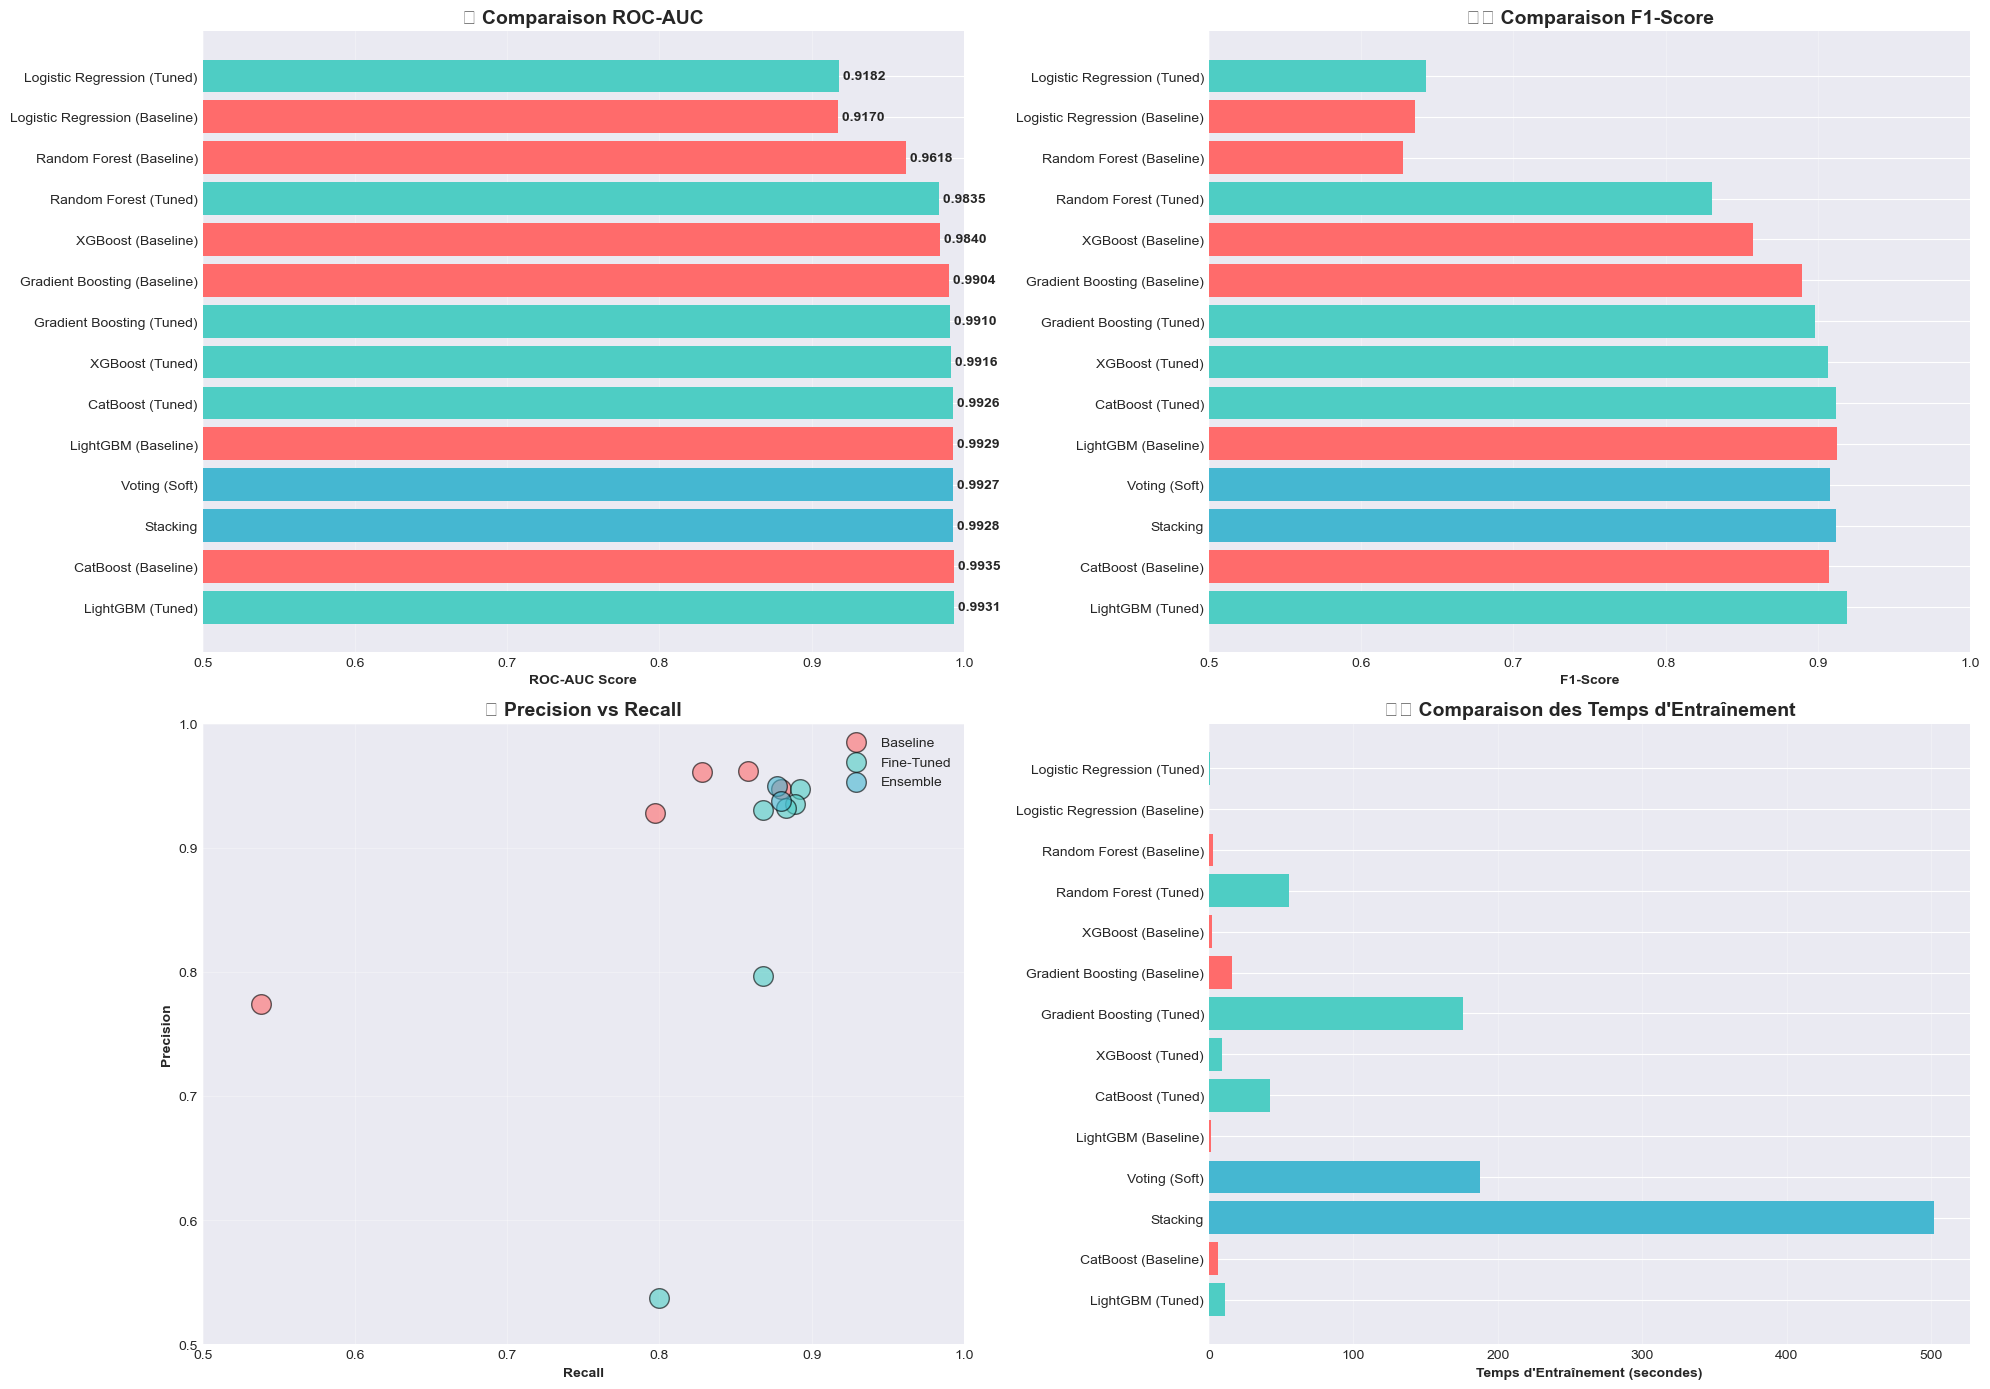

In [16]:
def plot_comprehensive_comparison(df_comparison):
    """
    Visualise la comparaison de tous les modèles
    """
    fig, axes = plt.subplots(2, 2, figsize=(20, 14))
    
    # Palette de couleurs par type
    type_colors = {
        'Baseline': '#FF6B6B',
        'Fine-Tuned': '#4ECDC4',
        'Ensemble': '#45B7D1'
    }
    colors = [type_colors[t] for t in df_comparison['Type']]
    
    # 1. ROC-AUC Comparison
    axes[0, 0].barh(df_comparison['Modèle'], df_comparison['ROC-AUC'], color=colors)
    axes[0, 0].set_xlabel('ROC-AUC Score', fontweight='bold')
    axes[0, 0].set_title('🎯 Comparaison ROC-AUC', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlim([0.5, 1.0])
    axes[0, 0].grid(axis='x', alpha=0.3)
    
    # Ajouter les valeurs
    for i, (idx, row) in enumerate(df_comparison.iterrows()):
        axes[0, 0].text(row['ROC-AUC'], i, f" {row['ROC-AUC']:.4f}", 
                       va='center', fontweight='bold')
    
    # 2. F1-Score Comparison
    axes[0, 1].barh(df_comparison['Modèle'], df_comparison['F1-Score'], color=colors)
    axes[0, 1].set_xlabel('F1-Score', fontweight='bold')
    axes[0, 1].set_title('⚖️ Comparaison F1-Score', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlim([0.5, 1.0])
    axes[0, 1].grid(axis='x', alpha=0.3)
    
    # 3. Precision vs Recall
    for type_name, color in type_colors.items():
        df_type = df_comparison[df_comparison['Type'] == type_name]
        axes[1, 0].scatter(df_type['Recall'], df_type['Precision'], 
                          s=200, alpha=0.6, c=color, label=type_name, edgecolors='black')
    
    axes[1, 0].set_xlabel('Recall', fontweight='bold')
    axes[1, 0].set_ylabel('Precision', fontweight='bold')
    axes[1, 0].set_title('🎯 Precision vs Recall', fontsize=14, fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_xlim([0.5, 1.0])
    axes[1, 0].set_ylim([0.5, 1.0])
    
    # 4. Training Time Comparison
    axes[1, 1].barh(df_comparison['Modèle'], df_comparison['Temps (s)'], color=colors)
    axes[1, 1].set_xlabel('Temps d\'Entraînement (secondes)', fontweight='bold')
    axes[1, 1].set_title('⏱️ Comparaison des Temps d\'Entraînement', fontsize=14, fontweight='bold')
    axes[1, 1].grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Afficher les visualisations
plot_comprehensive_comparison(df_comparison)

## 9. 📈 Courbes ROC - Comparaison Baseline vs Tuned vs Ensemble

In [23]:
def get_roc_auc(metrics):
    for key in ["roc_auc", "ROC-AUC", "roc_auc_score"]:
        if key in metrics:
            return metrics[key]
    return None


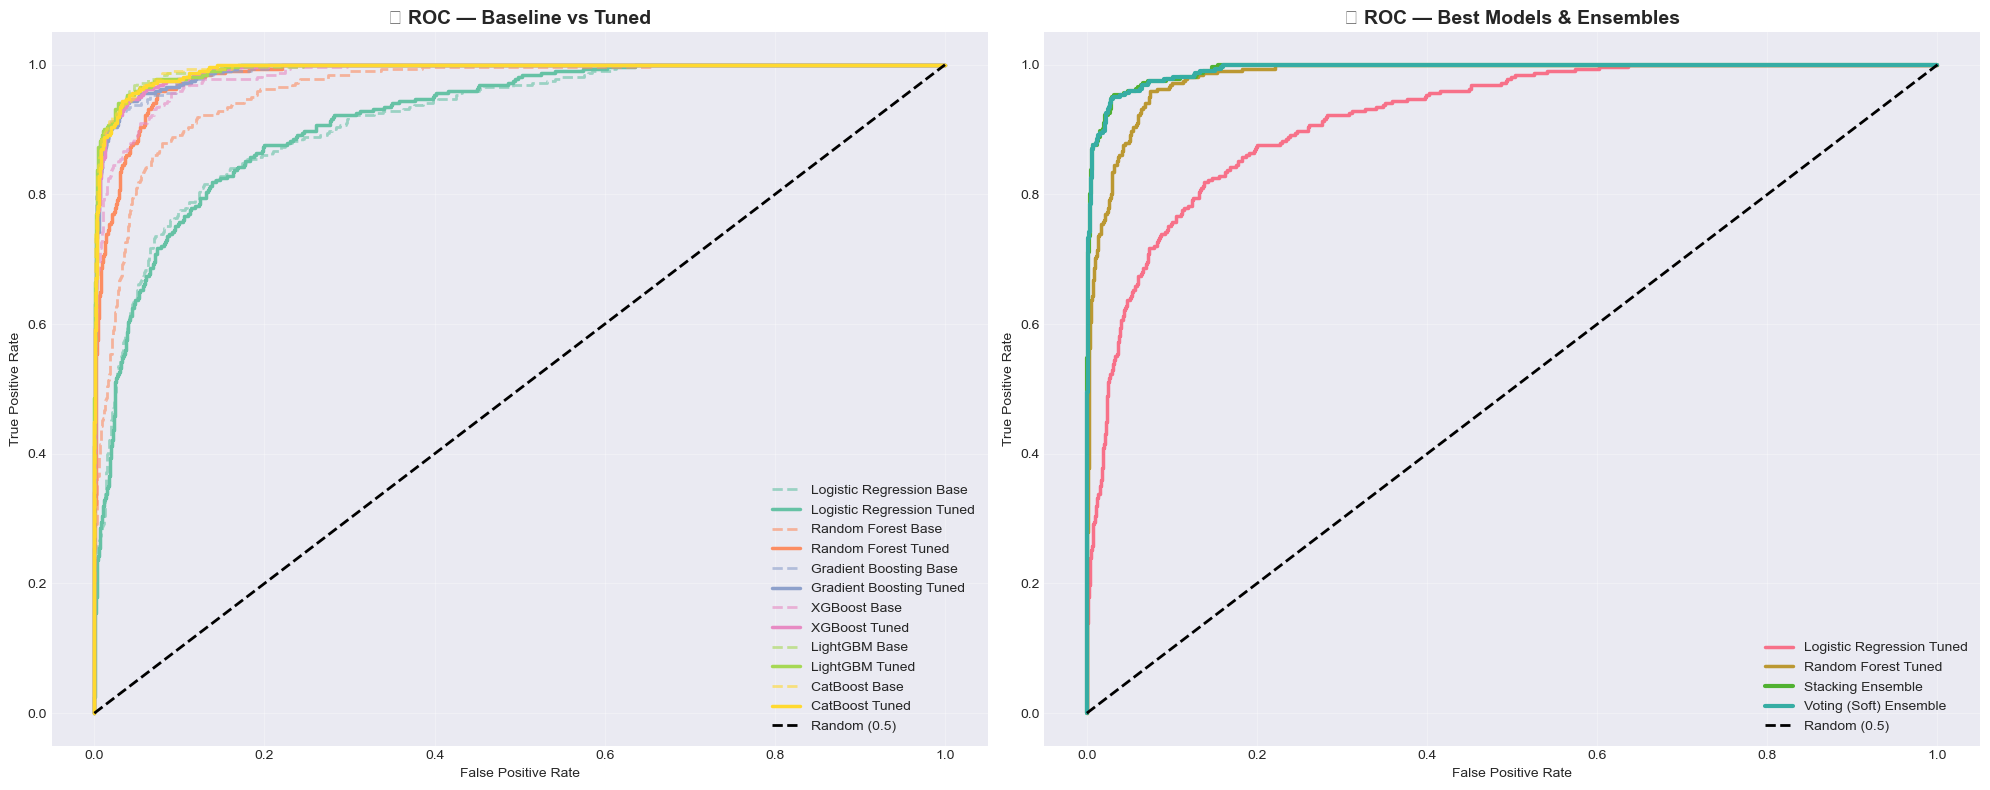

In [25]:
def plot_comprehensive_roc_curves(
    baseline_results,
    tuned_results,
    ensemble_results,
    y_test
):
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    colors = plt.cm.Set2.colors

    # -------- Plot 1: Baseline vs Tuned --------
    for idx, (name, base_metrics) in enumerate(baseline_results.items()):
        base_scores = extract_scores(base_metrics)
        fpr, tpr, _ = roc_curve(y_test, base_scores)

        roc_auc = get_roc_auc(base_metrics)
        label = f"{name} Base"
        if roc_auc is not None:
            label += f" ({roc_auc:.3f})"

        axes[0].plot(
            fpr, tpr, "--",
            color=colors[idx % len(colors)],
            lw=2,
            alpha=0.6,
            label=label
        )

        if name in tuned_results:
            tuned_metrics = tuned_results[name]
            tuned_scores = extract_scores(tuned_metrics)
            fpr_t, tpr_t, _ = roc_curve(y_test, tuned_scores)

            roc_auc_t = get_roc_auc(tuned_metrics)
            label_t = f"{name} Tuned"
            if roc_auc_t is not None:
                label_t += f" ({roc_auc_t:.3f})"

            axes[0].plot(
                fpr_t, tpr_t, "-",
                color=colors[idx % len(colors)],
                lw=2.5,
                label=label_t
            )

    axes[0].plot([0, 1], [0, 1], "k--", lw=2, label="Random (0.5)")
    axes[0].set_title("📈 ROC — Baseline vs Tuned", fontsize=14, fontweight="bold")
    axes[0].set_xlabel("False Positive Rate")
    axes[0].set_ylabel("True Positive Rate")
    axes[0].legend()
    axes[0].grid(alpha=0.3)

    # -------- Plot 2: Best Tuned + Ensembles --------
    best_tuned = sorted(
        tuned_results.items(),
        key=lambda x: get_roc_auc(x[1]) or 0,
        reverse=True
    )[:2]

    for name, metrics in best_tuned:
        scores = extract_scores(metrics)
        fpr, tpr, _ = roc_curve(y_test, scores)

        roc_auc_t = get_roc_auc(metrics)
        label = f"{name} Tuned"
        if roc_auc_t is not None:
            label += f" ({roc_auc_t:.3f})"

        axes[1].plot(fpr, tpr, lw=2.5, label=label)

    for name, metrics in ensemble_results.items():
        scores = extract_scores(metrics)
        fpr, tpr, _ = roc_curve(y_test, scores)

        roc_auc_e = get_roc_auc(metrics)
        label = f"{name} Ensemble"
        if roc_auc_e is not None:
            label += f" ({roc_auc_e:.3f})"

        axes[1].plot(fpr, tpr, lw=3, label=label)

    axes[1].plot([0, 1], [0, 1], "k--", lw=2, label="Random (0.5)")
    axes[1].set_title("📈 ROC — Best Models & Ensembles", fontsize=14, fontweight="bold")
    axes[1].set_xlabel("False Positive Rate")
    axes[1].set_ylabel("True Positive Rate")
    axes[1].legend()
    axes[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()



plot_comprehensive_roc_curves(
    baseline_results,
    tuned_results,
    ensemble_results,
    y_test
)


## 10. 📊 Analyse des Améliorations

In [38]:
def get_metric(metrics: dict, keys: list):
    if metrics is None or not isinstance(metrics, dict):
        return None

    for key in keys:
        if key in metrics:
            return metrics[key]

    if "metrics" in metrics and isinstance(metrics["metrics"], dict):
        for key in keys:
            if key in metrics["metrics"]:
                return metrics["metrics"][key]

    return None


In [39]:
def analyze_improvements(baseline_results, tuned_results, ensemble_results):
    """
    Analyse des améliorations multi-métriques :
    ROC-AUC, F1, Recall, Precision
    """
    print(f"\n{'='*90}")
    print("📊 ANALYSE DES AMÉLIORATIONS — MULTI-MÉTRIQUES (CHURN)")
    print(f"{'='*90}\n")

    metrics_map = {
        "roc_auc": ["roc_auc", "ROC-AUC"],
        "f1": ["f1_score", "F1", "F1(churn)"],
        "recall": ["recall", "Recall", "Recall(churn)"],
        "precision": ["precision", "Precision", "Precision(churn)"],
    }

    rows = []

    # ==================================================
    # Baseline -> Tuned
    # ==================================================
    print("🔧 IMPACT DU FINE-TUNING (Baseline → Tuned)")
    print("─" * 90)

    for name in baseline_results.keys():
        base = baseline_results.get(name)
        tuned = tuned_results.get(name)

        row = {"Modèle": name}

        valid = True
        for metric, keys in metrics_map.items():
            b = get_metric(base, keys)
            t = get_metric(tuned, keys)

            if b is None or t is None:
                valid = False
                break

            row[f"Baseline {metric.upper()}"] = b
            row[f"Tuned {metric.upper()}"] = t
            row[f"Gain {metric.upper()}"] = t - b
            row[f"Gain % {metric.upper()}"] = ((t - b) / b) * 100

        if not valid:
            print(f"⚠️  {name}: métriques incomplètes, ignoré.")
            continue

        rows.append(row)

        print(f"\n{name}:")
        for metric in metrics_map:
            print(
                f"  {metric.upper():9s}: "
                f"{row[f'Baseline {metric.upper()}']:.4f} → "
                f"{row[f'Tuned {metric.upper()}']:.4f} "
                f"({row[f'Gain % {metric.upper()}']:+.2f}%)"
            )

    df_improvements = pd.DataFrame(rows)

    # ==================================================
    # Meilleurs modèles par métrique
    # ==================================================
    print(f"\n\n🏆 MEILLEURS MODÈLES PAR MÉTRIQUE")
    print("─" * 90)

    def best_model(results, keys):
        valid = {
            name: get_metric(metrics, keys)
            for name, metrics in results.items()
            if get_metric(metrics, keys) is not None
        }
        return max(valid.items(), key=lambda x: x[1]) if valid else None

    for metric, keys in metrics_map.items():
        best_b = best_model(baseline_results, keys)
        best_t = best_model(tuned_results, keys)
        best_e = best_model(ensemble_results, keys)

        print(f"\n🔹 {metric.upper()}:")
        if best_b:
            print(f"  Baseline : {best_b[0]} ({best_b[1]:.4f})")
        if best_t:
            print(f"  Tuned    : {best_t[0]} ({best_t[1]:.4f})")
        if best_e:
            print(f"  Ensemble : {best_e[0]} ({best_e[1]:.4f})")

    # ==================================================
    # Amélioration globale pondérée (métier churn)
    # ==================================================
    print(f"\n\n💡 AMÉLIORATION GLOBALE (SCORE COMPOSITE)")
    print("─" * 90)

    weights = {
        "roc_auc": 0.35,
        "f1": 0.30,
        "recall": 0.25,
        "precision": 0.10,
    }

    def composite_score(metrics):
        score = 0
        for metric, w in weights.items():
            v = get_metric(metrics, metrics_map[metric])
            if v is None:
                return None
            score += w * v
        return score

    best_baseline = best_model(
        baseline_results,
        sum(metrics_map.values(), [])
    )
    best_ensemble = best_model(
        ensemble_results,
        sum(metrics_map.values(), [])
    )

    if best_baseline and best_ensemble:
        base_score = composite_score(baseline_results[best_baseline[0]])
        ens_score = composite_score(ensemble_results[best_ensemble[0]])

        print(f"Baseline : {best_baseline[0]} → Score {base_score:.4f}")
        print(f"Ensemble : {best_ensemble[0]} → Score {ens_score:.4f}")
        print(
            f"Gain global : {ens_score - base_score:+.4f} "
            f"({((ens_score - base_score) / base_score) * 100:+.2f}%)"
        )
    else:
        print("Impossible de calculer l'amélioration globale.")

    return df_improvements
df_improvements = analyze_improvements(
    baseline_results,
    tuned_results,
    ensemble_results
)



📊 ANALYSE DES AMÉLIORATIONS — MULTI-MÉTRIQUES (CHURN)

🔧 IMPACT DU FINE-TUNING (Baseline → Tuned)
──────────────────────────────────────────────────────────────────────────────────────────

Logistic Regression:
  ROC_AUC  : 0.9170 → 0.9182 (+0.13%)
  F1       : 0.6352 → 0.6428 (+1.19%)
  RECALL   : 0.5385 → 0.8000 (+48.57%)
  PRECISION: 0.7743 → 0.5372 (-30.63%)

Random Forest:
  ROC_AUC  : 0.9618 → 0.9835 (+2.26%)
  F1       : 0.6275 → 0.8306 (+32.38%)
  RECALL   : 0.4923 → 0.8677 (+76.25%)
  PRECISION: 0.8649 → 0.7966 (-7.89%)

Gradient Boosting:
  ROC_AUC  : 0.9904 → 0.9910 (+0.07%)
  F1       : 0.8893 → 0.8981 (+0.99%)
  RECALL   : 0.8277 → 0.8677 (+4.83%)
  PRECISION: 0.9607 → 0.9307 (-3.12%)

XGBoost:
  ROC_AUC  : 0.9840 → 0.9916 (+0.77%)
  F1       : 0.8576 → 0.9068 (+5.73%)
  RECALL   : 0.7969 → 0.8831 (+10.81%)
  PRECISION: 0.9283 → 0.9318 (+0.38%)

LightGBM:
  ROC_AUC  : 0.9929 → 0.9931 (+0.02%)
  F1       : 0.9123 → 0.9192 (+0.76%)
  RECALL   : 0.8800 → 0.8923 (+1.40%)
  PR

## 11. 💾 Sauvegarde du Meilleur Modèle Final

In [36]:
import os
import pickle
from datetime import datetime


# ======================================================================
# 1️⃣ Utilitaire robuste pour lire une métrique (clé hétérogène)
# ======================================================================

def get_metric(metrics: dict, keys: list):
    if metrics is None or not isinstance(metrics, dict):
        return None

    for key in keys:
        if key in metrics:
            return metrics[key]

    if "metrics" in metrics and isinstance(metrics["metrics"], dict):
        for key in keys:
            if key in metrics["metrics"]:
                return metrics["metrics"][key]

    return None


# ======================================================================
# 2️⃣ Score global pondéré (logique métier churn)
# ======================================================================

def compute_global_score(metrics, weights):
    roc_auc = get_metric(metrics, ["roc_auc", "ROC-AUC"])
    f1 = get_metric(metrics, ["f1_score", "F1", "F1(churn)"])
    recall = get_metric(metrics, ["recall", "Recall", "Recall(churn)"])
    precision = get_metric(metrics, ["precision", "Precision", "Precision(churn)"])

    if None in (roc_auc, f1, recall, precision):
        return None

    return (
        weights["roc_auc"] * roc_auc +
        weights["f1_score"] * f1 +
        weights["recall"] * recall +
        weights["precision"] * precision
    )


# ======================================================================
# 3️⃣ Sauvegarde du meilleur modèle global (multi-métriques)
# ======================================================================

def save_best_final_model(
    baseline_results,
    tuned_results,
    ensemble_results,
    tuned_models,
    ensemble_models,
    best_params,
    processor_dir
):
    """
    Sélectionne et sauvegarde le meilleur modèle selon un score composite :
    ROC-AUC / F1 / Recall / Precision
    """

    print(f"\n{'='*80}")
    print("💾 SAUVEGARDE DU MEILLEUR MODÈLE FINAL (MULTI-MÉTRIQUES)")
    print(f"{'='*80}\n")

    # Pondérations métier churn
    weights = {
        "roc_auc": 0.35,
        "f1_score": 0.30,
        "recall": 0.25,
        "precision": 0.10
    }

    all_results = {}
    all_models = {}

    # ------------------------------
    # Baselines
    # ------------------------------
    for name, results in baseline_results.items():
        key = f"{name} (Baseline)"
        all_results[key] = results
        if "model" in results:
            all_models[key] = results["model"]

    # ------------------------------
    # Tuned
    # ------------------------------
    for name, results in tuned_results.items():
        key = f"{name} (Tuned)"
        all_results[key] = results
        all_models[key] = tuned_models.get(name)

    # ------------------------------
    # Ensembles
    # ------------------------------
    for name, results in ensemble_results.items():
        all_results[name] = results
        all_models[name] = ensemble_models.get(name)

    # ------------------------------
    # Calcul des scores globaux
    # ------------------------------
    scores = {}

    for name, metrics in all_results.items():
        score = compute_global_score(metrics, weights)
        if score is not None:
            scores[name] = score

    if not scores:
        raise ValueError("❌ Aucun modèle avec métriques complètes.")

    # ------------------------------
    # Sélection du meilleur modèle
    # ------------------------------
    best_model_name = max(scores, key=scores.get)
    best_model = all_models[best_model_name]
    best_metrics = all_results[best_model_name]

    # Récupération métriques propres
    roc_auc = get_metric(best_metrics, ["roc_auc", "ROC-AUC"])
    f1 = get_metric(best_metrics, ["f1_score", "F1", "F1(churn)"])
    recall = get_metric(best_metrics, ["recall", "Recall", "Recall(churn)"])
    precision = get_metric(best_metrics, ["precision", "Precision", "Precision(churn)"])
    accuracy = get_metric(best_metrics, ["accuracy", "Accuracy"])

    print(f"🏆 MEILLEUR MODÈLE GLOBAL : {best_model_name}")
    print(f"   Score global : {scores[best_model_name]:.4f}")
    print(f"   ROC-AUC      : {roc_auc:.4f}")
    print(f"   F1           : {f1:.4f}")
    print(f"   Recall       : {recall:.4f}")
    print(f"   Precision    : {precision:.4f}\n")

    # ------------------------------
    # Dossier models
    # ------------------------------
    models_dir = os.path.join(processor_dir, "models")
    os.makedirs(models_dir, exist_ok=True)

    # ------------------------------
    # Sauvegarde du modèle
    # ------------------------------
    model_path = os.path.join(models_dir, "best_model_final.pkl")
    with open(model_path, "wb") as f:
        pickle.dump(best_model, f)

    print(f"✅ Modèle sauvegardé : {model_path}")

    # ------------------------------
    # Métadonnées
    # ------------------------------
    model_type = (
        "Ensemble"
        if "Stacking" in best_model_name or "Voting" in best_model_name
        else "Fine-Tuned"
        if "(Tuned)" in best_model_name
        else "Baseline"
    )

    metadata = {
        "model_name": best_model_name,
        "model_type": model_type,
        "global_score": scores[best_model_name],
        "metrics": {
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1_score": f1,
            "roc_auc": roc_auc,
        },
        "training_time_sec": best_metrics.get("training_time"),
        "best_params": best_params if "(Tuned)" in best_model_name else None,
        "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    }

    metadata_path = os.path.join(models_dir, "best_model_final_metadata.pkl")
    with open(metadata_path, "wb") as f:
        pickle.dump(metadata, f)

    print(f"✅ Métadonnées sauvegardées : {metadata_path}")

    print("\n✅ Sauvegarde terminée avec succès !")

    return best_model_name, best_model, metadata


In [37]:
best_model_name, best_model, metadata = save_best_final_model(
    baseline_results=baseline_results,
    tuned_results=tuned_results,
    ensemble_results=ensemble_results,
    tuned_models=tuned_models,
    ensemble_models=ensemble_models,
    best_params=best_params,
    processor_dir=PROCESSOR_DIR
)



💾 SAUVEGARDE DU MEILLEUR MODÈLE FINAL (MULTI-MÉTRIQUES)

🏆 MEILLEUR MODÈLE GLOBAL : LightGBM (Tuned)
   Score global : 0.9412
   ROC-AUC      : 0.9931
   F1           : 0.9192
   Recall       : 0.8923
   Precision    : 0.9477

✅ Modèle sauvegardé : processors\models\best_model_final.pkl
✅ Métadonnées sauvegardées : processors\models\best_model_final_metadata.pkl

✅ Sauvegarde terminée avec succès !


## 13. 🎯 Export des Résultats Finaux

In [41]:
# Sauvegarder le tableau comparatif complet en CSV
comparison_csv_path = os.path.join(PROCESSOR_DIR, 'model_comparison_final.csv')
df_comparison.to_csv(comparison_csv_path, index=False)
print(f"✅ Tableau comparatif sauvegardé: {comparison_csv_path}")

# Sauvegarder le tableau des améliorations en CSV
improvements_csv_path = os.path.join(PROCESSOR_DIR, 'model_improvements.csv')
df_improvements.to_csv(improvements_csv_path, index=False)
print(f"✅ Tableau des améliorations sauvegardé: {improvements_csv_path}")

# Sauvegarder tous les résultats en pickle
all_results_path = os.path.join(PROCESSOR_DIR, 'all_results_final.pkl')
with open(all_results_path, 'wb') as f:
    pickle.dump({
        'baseline_results': baseline_results,
        'tuned_results': tuned_results,
        'ensemble_results': ensemble_results,
        'comparison_table': df_comparison,
        'improvements_table': df_improvements,
        'best_model_name': best_model_name,
        'best_params': best_params,
        'metadata': metadata
    }, f)
print(f"✅ Tous les résultats sauvegardés: {all_results_path}")

print(f"\n{'='*80}")
print("🎉 NOTEBOOK TERMINÉ AVEC SUCCÈS!")
print(f"{'='*80}")
print("\n📦 Fichiers générés:")
print(f"   • {comparison_csv_path}")
print(f"   • {improvements_csv_path}")
print(f"   • {all_results_path}")
print(f"   • {os.path.join(PROCESSOR_DIR, 'models/best_model_final.pkl')}")
print(f"   • {os.path.join(PROCESSOR_DIR, 'models/all_tuned_models.pkl')}")
print(f"   • {os.path.join(PROCESSOR_DIR, 'models/ensemble_models.pkl')}")
print(f"   • {os.path.join(PROCESSOR_DIR, 'modeling_report_final.txt')}")
print("\n🚀 Pipeline complet exécuté: Baseline → Fine-Tuning → Stacking → Évaluation")
print(f"\n🏆 Meilleur modèle: {best_model_name}")
print(f"   ROC-AUC: {metadata['metrics']['roc_auc']:.4f}")
print("\n✅ Prêt pour le déploiement!")

✅ Tableau comparatif sauvegardé: processors\model_comparison_final.csv
✅ Tableau des améliorations sauvegardé: processors\model_improvements.csv
✅ Tous les résultats sauvegardés: processors\all_results_final.pkl

🎉 NOTEBOOK TERMINÉ AVEC SUCCÈS!

📦 Fichiers générés:
   • processors\model_comparison_final.csv
   • processors\model_improvements.csv
   • processors\all_results_final.pkl
   • processors\models/best_model_final.pkl
   • processors\models/all_tuned_models.pkl
   • processors\models/ensemble_models.pkl
   • processors\modeling_report_final.txt

🚀 Pipeline complet exécuté: Baseline → Fine-Tuning → Stacking → Évaluation

🏆 Meilleur modèle: LightGBM (Tuned)
   ROC-AUC: 0.9931

✅ Prêt pour le déploiement!
